## $\alpha$ = -1, $\ell_0$ = 128

In [17]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import fgbuster
import pysm3
import pysm3.units as u
import pandas as pd
import emcee
import camb
from tqdm import tqdm

from scipy.optimize import minimize
import os

from fgbuster import CMB, Dust, Synchrotron, get_instrument, MixingMatrix

from getdist import MCSamples, plots

import warnings
warnings.filterwarnings('ignore')

In [18]:
specifications = {
    28: (39.9, 16.5),
    35: (31.9, 13.3),
    45: (24.8, 11.9),
    65: (17.1, 8.9),
    75: (14.91, 5.1),
    95: (11.7, 4.6),
    115: (9.72, 3.1),
    130: (8.59, 3.1),
    145: (7.70, 2.4),
    165: (6.77, 2.5),
    190: (5.88, 2.8),
    220: (5.08, 3.3),
    275: (4.06, 6.3),
    340: (3.28, 11.4),
    390: (2.86, 21.9),
    450: (2.48, 43.4),
    520: (2.14, 102.0),
    600: (1.86, 288.0),
    700: (1.59, 1122.0),
    850: (1.31, 9550.0),
}

# frequency_channels = np.array([28, 65, 115, 165, 275, 450, 700])
frequency_channels = np.array([28, 35, 45, 65, 75, 95, 115, 130, 145, 165, 190, 220, 275, 340, 390, 450, 520, 600, 700, 850])
nfreqs = len(frequency_channels)

noise_rms_pol = np.array([specifications[int(frequency)][1] for frequency in frequency_channels])
noise_rms_temp = noise_rms_pol / np.sqrt(2)

conv_factor = (np.pi/(180 * 60))

noise_rms_pol = noise_rms_pol * conv_factor
noise_rms_temp = noise_rms_temp * conv_factor

## 1. Simulations and Power Spectra

In [19]:
import os
import numpy as np
import pandas as pd
import healpy as hp

# Path to the theoretical power spectrum file.
thdl_file_path = 'cmb_new_ps_l.txt'

# Read the theoretical Dl power spectra.
# The file is assumed to have no header, with the first column as ℓ values (set as index)
# and columns 1, 2, 3, 4 corresponding to Dl for TT, EE, BB, and TE respectively.
thdl = pd.read_csv(thdl_file_path, sep='\t', header=None, index_col=0)

# Extract the ell values from the DataFrame index.
thdl_l = thdl.index.values

# Determine the maximum multipole from the input file.
lmax = int(np.max(thdl_l))

# Extract the theoretical Dl power spectra for TT, EE, BB, and TE.
thdl_tt = thdl[1].values
thdl_ee = thdl[2].values
thdl_bb = thdl[3].values
thdl_te = thdl[4].values

# Compute the normalization factor f(ℓ) = ℓ(ℓ+1)/(2π)
fl = (thdl_l * (thdl_l + 1)) / (2 * np.pi)

# Normalize the spectra (convert Dl to Cl) for ℓ >= 2.
thcl_tt = thdl_tt / fl
thcl_ee = thdl_ee / fl
thcl_bb = thdl_bb / fl
thcl_te = thdl_te / fl

# Create an array for Cl with shape (4, lmax+1), initializing all values to zero.
# The four rows correspond to TT, EE, BB, and TE respectively.
cmb_theory_cl = np.zeros((4, lmax+1), dtype=np.float64)
cmb_theory_cl[0, 2:] = thcl_tt
cmb_theory_cl[1, 2:] = thcl_ee
cmb_theory_cl[2, 2:] = thcl_bb
cmb_theory_cl[3, 2:] = thcl_te

In [20]:
nside = 128
nlmax = 2 * nside
alpha = -1
ell0 = nlmax/2

In [21]:
foreground_config = pysm3.Sky(nside=nside, 
                    preset_strings=["d0", "s0"],  # Synchrotron ('s0') and Thermal Dust ('d0') models
                    output_unit="uK_CMB")  # Output units in microKelvin (CMB temperature units)

In [22]:
foreground_balms = np.zeros((nfreqs, hp.Alm.getsize(nlmax)), dtype = np.complex128)
foreground_bcls = np.zeros((nfreqs, nlmax+1))
for j, frequency in enumerate(frequency_channels):
    foreground_input_map = foreground_config.get_emission(frequency * u.GHz)
    foreground_balms[j] = hp.map2alm(foreground_input_map, lmax = nlmax)[2]  #only [2] which is B-mode is chosen
    foreground_bcls[j] = hp.anafast(foreground_input_map, lmax = nlmax)[2]

In [23]:
# Noise spectra function using a depth array (sigma_rms of size Nf)
def Noise_Spectra(noise_rms, alpha_knee, l_knee, nlmax):
    Nf_local = len(noise_rms)
    N = np.zeros((nlmax+1, Nf_local, Nf_local))
    noise_white = noise_rms**2 #np.power(noise_rms, 2.0)
    for l in range(2, nlmax+1):
        noise_sp = noise_white * (1 + (l / l_knee)**alpha_knee)
        N[l] = np.diag(noise_sp)
    return N

In [24]:
def Noise_White(noise_rms, nlmax):
    Nf_local = len(noise_rms)
    N = np.zeros((nlmax+1, Nf_local, Nf_local))
    noise_white = noise_rms**2 #np.power(noise_rms, 2.0)
    for l in range(2, nlmax+1):
        noise_sp = noise_white #* (1 + (l / l_knee)**alpha_knee)
        N[l] = np.diag(noise_sp)
    return N

In [25]:
def CMB_Spectra(cmb_spec, nlmax):
    Nf_local = len(frequency_channels)
    CMB_sp = np.zeros((nlmax+1, Nf_local, Nf_local))
    for l in range(2, nlmax+1):
        CMB_sp[l] += cmb_spec[l]
    return CMB_sp

In [26]:
#takes as input the maps and finds the cross-power between the maps
def Observation_Spectra(maps):
    Nf_local = maps.shape[0]
    nside_local = hp.get_nside(maps[0])
    nlmax = 2*nside_local
    
    # Allocate array for Cl; for each l, we have an n_channels x n_channels matrix.
    C = np.zeros((nlmax+1, Nf_local, Nf_local))
    
    # Loop over channel pairs.
    for f in range(Nf_local):
        for g in range(f, Nf_local):
            # Compute the cross-power spectrum between channel f and g.
            C_fg = hp.anafast(maps[f], maps[g], lmax = nlmax)[2]
            C[:, f, g] = C_fg
            C[:, g, f] = C_fg  # symmetry: C_ij = C_ji.
    
    return C

In [27]:
def Observation_Spectra(alms):
    Nf_local = alms.shape[0]
    alm_size = alms.shape[-1]
    nlmax = hp.Alm.getlmax(alm_size)
    
    # Allocate array for Cl; for each l, we have an n_channels x n_channels matrix.
    C = np.zeros((nlmax+1, Nf_local, Nf_local))
    
    # Loop over channel pairs.
    for f in range(Nf_local):
        for g in range(f, Nf_local):
            # Compute the cross-power spectrum between channel f and g.
            C_fg = hp.alm2cl(alms[f], alms[g], lmax = nlmax)
            C[:, f, g] = C_fg
            C[:, g, f] = C_fg  # symmetry: C_ij = C_ji.
    
    return C

In [28]:
#creating a combined observation power spectrum of cmb, foreground and noise of shape (nlmax+1, nfreqs, nfreqs) for only B-modes

#cmb
cmb_sp = CMB_Spectra(cmb_theory_cl[2], nlmax)

#foregrounds
foreground_sp = Observation_Spectra(foreground_balms)
# foreground_sp = Observation_Spectra(foreground_input_maps)

#noise
noise_sp = Noise_Spectra(noise_rms_pol, alpha_knee = alpha, l_knee = ell0, nlmax = nlmax)

combined_obs_sp = cmb_sp + foreground_sp + noise_sp

In [29]:
def generate_initial_params(true_params, pct=0.1):
    lb = true_params - pct * np.abs(true_params)
    ub = true_params + pct * np.abs(true_params)
    return np.random.uniform(lb, ub)

## 2. Ensemble Averaged Likelihood

In [30]:
cmb = CMB()
dust = Dust(353)
synch = Synchrotron(20)
sky_components = [cmb, dust, synch]
ncomps = len(sky_components)

MM = MixingMatrix(*sky_components)
A_evaluator = MM.evaluator(frequency_channels)

In [31]:
def EnsembleAverageNegative2LogLikelihood(params, noise_rms, obs_sp, noise_sp):

    # Determine maximum multipole from Cl_d.
    nlmax_local = obs_sp.shape[0] - 1
    Nf_local = obs_sp.shape[1]
    
    # Unpack parameters.
    alpha_knee = params[0]
    l_knee = params[1]
    spectral_params = params[2:]
    
    # Evaluate the mixing matrix A (assumed to be computed from spectral_params).
    A = A_evaluator(spectral_params)  # Expected shape: (n_freq, n_components)

    # Compute noise spectra N for each multipole.
    # Noise_Spectra returns an array of shape (lmax_local+1, n_freq, n_freq).
    N = Noise_Spectra(noise_rms, alpha_knee, l_knee, nlmax_local)
    
    total = 0.0
    for l in range(2, nlmax_local + 1):
        # Get noise covariance for multipole l.
        N_l = N[l]  # shape: (n_freq, n_freq)
        N_inv_l = np.linalg.inv(N_l)
        
        C_l = obs_sp[l]
        # N_l_th = noise_sp[l]
        
        # First term: (2l+1)*Tr[N_l^{-1} C^d_l]
        D_term = np.trace(np.dot(N_inv_l, C_l))
        
        # Compute P_l = A^T N_l^{-1} A, then its inverse.
        P_l = np.dot(np.dot(A.T, N_inv_l), A)
        P_inv_l = np.linalg.inv(P_l)
        
        # Second term: (2l+1)*Tr[P_l^{-1} A^T N_l^{-1} C^d_l N_l^{-1} A]
        X_term = np.trace(np.dot(P_inv_l, np.dot(np.dot(A.T, N_inv_l), np.dot(C_l, np.dot(N_inv_l, A)))))
        
        # Third term: (2l+1)[ln(2π) + ln(det(N_l))]
        M_term = Nf_local * np.log(2*np.pi) + np.log(np.linalg.det(N_l))
        
        total += (2*l + 1) * (D_term - X_term + M_term)

        #bias corrections
        ANA = P_l
        W = P_inv_l @ A.T @ N_inv_l

        N_l_th = Noise_White(noise_rms, nlmax_local)[l]
        
        #bias term 1: (2l+1)*Tr[W^T A^T N_l^{-1} N_l_th]
        b1 = np.trace(W.T @ A.T @ N_inv_l @ N_l_th)

        #bias term 2: (2l+1)*Tr[N_l_th N_l^{-1} A W]
        b2 = np.trace(N_l_th @ N_inv_l @ A @ W)

        #bias term 3: (2l+1)*Tr[W^T A^T N_l^{-1} A W N_l_th]
        b3 = np.trace(W.T @ A.T @ N_inv_l @ A @ W @ N_l_th)

        total+= (2*l + 1) * (b1 + b2 - b3)
        
    return total

## 3. Minimization

In [32]:
true_params = np.array([-1, 128, 1.54, 20.0, -3.0])

initial_params = generate_initial_params(true_params, pct=0.2)
print("\n All initial parameters:")
print(initial_params)

# Minimize the ensemble average negative 2 log-likelihood using Nelder-Mead.
result = minimize(
EnsembleAverageNegative2LogLikelihood,
initial_params,
args=(noise_rms_pol, combined_obs_sp, noise_sp),
method='Nelder-Mead',
options={'fatol': 1e-4, 'xatol': 1e-4, 'maxfev': 10000, 'disp': False, 'adaptive': True}
)

all_estimated_params = result.x
print("\nAll estimated spectral parameters:")
print(all_estimated_params)


 All initial parameters:
[ -1.1985382  107.65390448   1.3222837   20.54145376  -2.67184628]

All estimated spectral parameters:
[ -1.00000282 108.79992898   1.54000001  19.99999953  -2.99999936]


## 4. Minimization

In [33]:
def Positive2LogLikelihood(params, noise_rms, obs_sp, noise_sp):
    return -1 * EnsembleAverageNegative2LogLikelihood(params, noise_rms, obs_sp, noise_sp)

In [34]:
def log_prior(params):
    alpha, ell0, beta_d, T_d, beta_s = params
    if -5 < alpha < 0 and 0 < ell0 < nlmax+10 and 1 < beta_d < 2 and 10 < T_d < 25 and -5 < beta_s < -1:
        return 0.0
    return -np.inf

def log_posterior(params, noise_rms, obs_sp, noise_sp):
    lp = log_prior(params)
    if not np.isfinite(lp):
        # print("Prior is -inf for params:", params)
        return -np.inf
    ll = EnsembleAverageNegative2LogLikelihood(params, noise_rms, obs_sp, noise_sp)
    if not np.isfinite(ll):
        # print("Likelihood is -inf for params:", params)
        return -np.inf
    return -(lp + ll)

In [35]:
import emcee
def get_samples(data, init, noise_sp):
    ndim = len(init)
    nwalkers = 3 * ndim  
    nsteps = 10000
    pos = init + 1e-1 * np.random.rand(nwalkers, ndim)
    
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_posterior, args=(noise_rms_pol, data, noise_sp),
    )
    
    state = sampler.run_mcmc(pos, nsteps//5, progress=True)
    sampler.reset()

    sampler.run_mcmc(state, nsteps, progress=True)
    samples = sampler.get_chain(flat=True)

    return samples

In [36]:
initial_params = [-1, 128., 1.5, 18, -2.8]
samples_fm = get_samples(combined_obs_sp, initial_params, noise_sp)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [7:01:25<00:00,  2.53s/it]


Removed no burn in


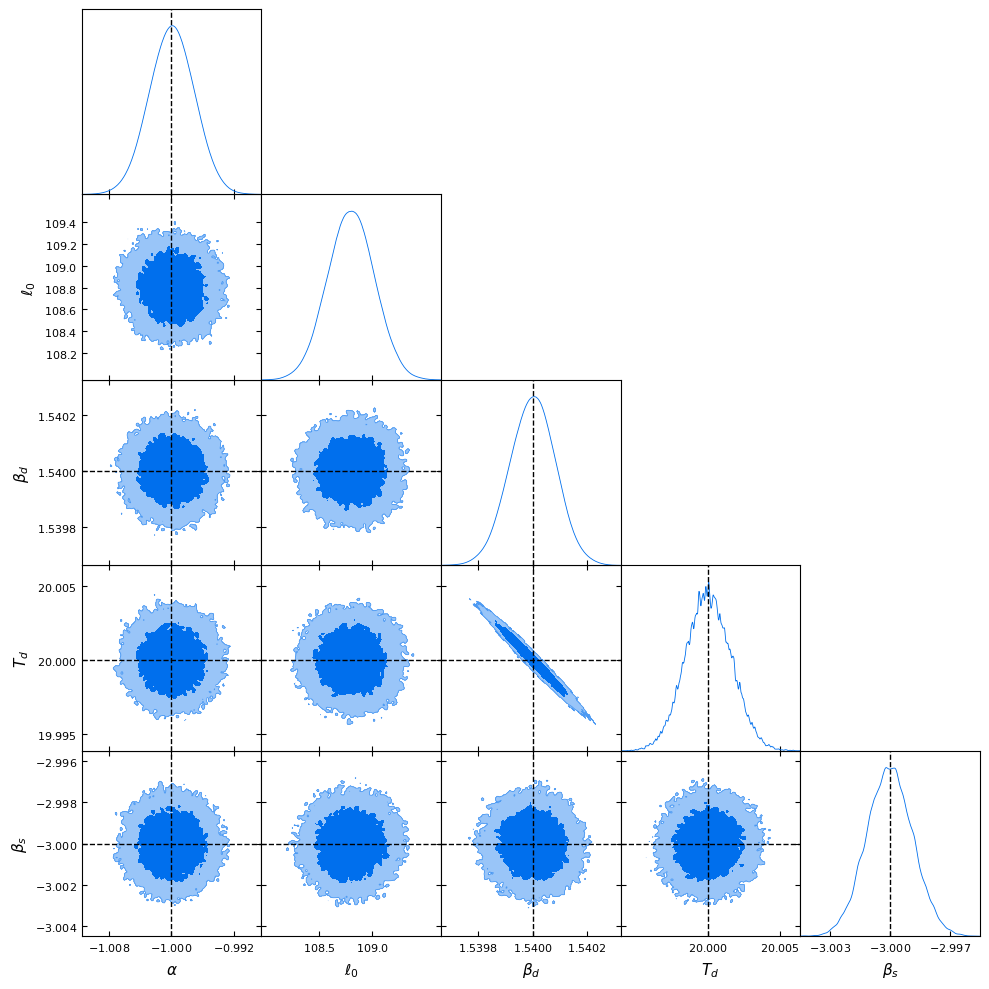

In [37]:
from getdist import MCSamples, plots

param_names = [("param1", r"\alpha"), ("param2", r"\ell_0"), ("param3", r"\beta_d"), ("param4", "T_d"), ("param5", r"\beta_s")]

s1 = MCSamples(samples=samples_fm, names=[p[0] for p in param_names], labels=[p[1] for p in param_names])

g = plots.get_subplot_plotter()
g.triangle_plot([s1], filled=True)

x_vals = [alpha, ell0, 1.54, 20, -3]  # example x positions
y_vals = x_vals  # example y positions

# Access the triangle axes
for ax in g.subplots.flatten():
    if ax is not None:
        for x in x_vals:
            ax.axvline(x, color='k', linestyle='--', linewidth=1)
        for y in y_vals:
            ax.axhline(y, color='k', linestyle='--', linewidth=1)

In [38]:
np.save('results/samples_a1l128_white.npy', samples_fm)

## 5. Estimating r

In [39]:
def get_weights(A, N):
    weights = []
    ll, mm = hp.Alm.getlm(nlmax)
    
    for ell in range(2, nlmax+1):
        N_inv_s = np.linalg.inv(N[ell])
        ANA = A.T @ N_inv_s @ A  
        AN = A.T @ N_inv_s
        weights.append((np.linalg.inv(ANA) @ AN))
           
    return np.array(weights)

In [40]:
params = np.mean(samples_fm, axis = 0)
params

array([ -0.99992782, 108.80147316,   1.54000004,  19.999997  ,
        -3.00002469])

In [41]:
W = get_weights(A_evaluator(params[2:]), Noise_Spectra(noise_rms_pol, alpha_knee = params[0], l_knee = params[1], nlmax = nlmax))[:,0]

WCW = np.einsum('ij,ijk,ik->i', W, combined_obs_sp[2:], W)
WNW = np.einsum('ij,ijk,ik->i', W, noise_sp[2:], W)

cmb_rec = np.zeros((nlmax+1))
cmb_rec[2:] = WCW

noise_res = np.zeros((nlmax+1))
noise_res[2:] = WNW

In [42]:
np.save('results/aps_a1l128_white.npy', np.stack([cmb_rec, noise_res]))